In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay
)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [ ]:
RANDOM_STATE = 42
sns.set(style="whitegrid", palette="pastel")

In [ ]:
df = pd.read_csv("UCI_Credit_Card.csv")
df.rename(columns={"default.payment.next.month": "default"}, inplace=True)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [ ]:
print(df.shape)
df.info()


print("\nMissing values per column:")
print(df.isnull().sum())

df.describe().T.head(10)


(30000, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         30000 non-null  int64  
 1   LIMIT_BAL  30000 non-null  float64
 2   SEX        30000 non-null  int64  
 3   EDUCATION  30000 non-null  int64  
 4   MARRIAGE   30000 non-null  int64  
 5   AGE        30000 non-null  int64  
 6   PAY_0      30000 non-null  int64  
 7   PAY_2      30000 non-null  int64  
 8   PAY_3      30000 non-null  int64  
 9   PAY_4      30000 non-null  int64  
 10  PAY_5      30000 non-null  int64  
 11  PAY_6      30000 non-null  int64  
 12  BILL_AMT1  30000 non-null  float64
 13  BILL_AMT2  30000 non-null  float64
 14  BILL_AMT3  30000 non-null  float64
 15  BILL_AMT4  30000 non-null  float64
 16  BILL_AMT5  30000 non-null  float64
 17  BILL_AMT6  30000 non-null  float64
 18  PAY_AMT1   30000 non-null  float64
 19  PAY_AMT2   30000 non-null  float64

,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


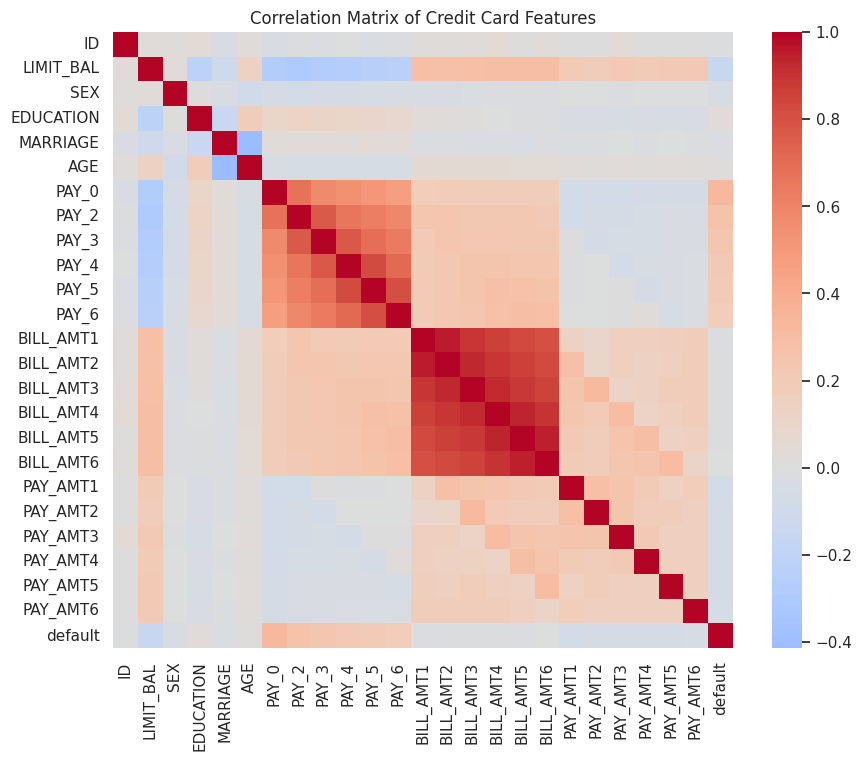

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Credit Card Features")
plt.show()


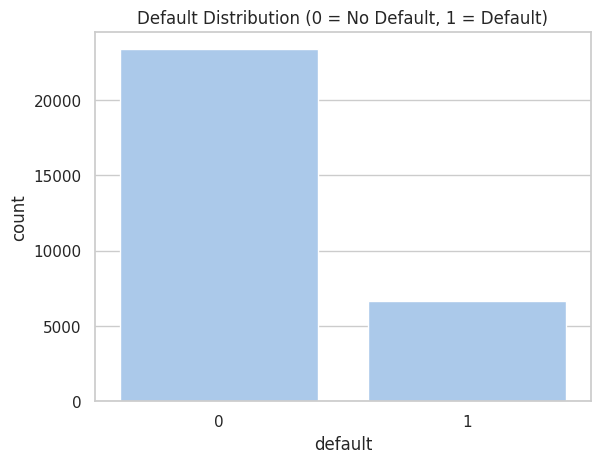

In [ ]:

sns.countplot(x="default", data=df)
plt.title("Default Distribution (0 = No Default, 1 = Default)")
plt.show()

In [ ]:
target = "default"
X = df.drop(columns=[target])
y = df[target]


categorical_cols = ["SEX", "EDUCATION", "MARRIAGE"] if "SEX" in df.columns else ["sex", "education", "marriage"]
numeric_cols = [c for c in X.columns if c not in categorical_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

In [ ]:
logreg_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=500, random_state=RANDOM_STATE))
])

rf_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE))
])


In [ ]:
models = {
    "Logistic Regression": logreg_pipe,
    "Random Forest": rf_pipe,
    "Gradient Boosting": Pipeline([
        ("preprocessor", preprocessor),
        ("model", GradientBoostingClassifier(random_state=RANDOM_STATE))
    ]),
    "XGBoost": Pipeline([
        ("preprocessor", preprocessor),
        ("model", XGBClassifier(
            n_estimators=300,
            learning_rate=0.1,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="logloss",
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]),
    "Support Vector Machine": Pipeline([
        ("preprocessor", preprocessor),
        ("model", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE))
    ]),
    "K-Nearest Neighbors": Pipeline([
        ("preprocessor", preprocessor),
        ("model", KNeighborsClassifier(n_neighbors=7))
    ])
}

results = {}

for name, model in models.items():
    print(f" Training {name} ...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="weighted"),
        "Recall": recall_score(y_test, y_pred, average="weighted"),
        "F1-Score": f1_score(y_test, y_pred, average="weighted"),
        "ROC-AUC": roc_auc_score(y_test, y_proba)
    }

results_df = pd.DataFrame(results).T.sort_values(by="ROC-AUC", ascending=False)
results_df


 Training Logistic Regression ...
 Training Random Forest ...
 Training Gradient Boosting ...
 Training XGBoost ...
 Training Support Vector Machine ...
 Training K-Nearest Neighbors ...


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Gradient Boosting,0.818000,0.800205,0.818000,0.796810,0.778591
XGBoost,0.817833,0.800152,0.817833,0.798670,0.772705
Random Forest,0.815667,0.797146,0.815667,0.795278,0.761903
Support Vector Machine,0.815667,0.797017,0.815667,0.792285,0.721463
Logistic Regression,0.809000,0.791000,0.809000,0.771407,0.710165
K-Nearest Neighbors,0.800167,0.777470,0.800167,0.780052,0.709972


In [ ]:
pip install --upgrade numpy scipy scikit-learn threadpoolctl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 90.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.3.4 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9"

In [ ]:
!pip install "numpy==2.0.2" --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 15.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.4
    Uninstalling numpy-2.3.4:
      Successfully uninstalled numpy-2.3.4


In [ ]:
import numpy as np
import sklearn

print("NumPy version:", np.__version__)
print("scikit-learn version:", sklearn.__version__)

NumPy version: 2.0.2
scikit-learn version: 1.7.2
